Ce fichier prédit des classes de stockages et non des delta stock journalier.

In [1]:
#imports
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import ticker
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split 

## Data Recovery

In [2]:
data = pd.read_csv('data_pre.csv', index_col = 0)

In [3]:
data

,Electricity demand,offshore,onshore,pv,river,lake,biogas,phs,battery,methanation,...,cost_phs,cost_bat,cost_met,cost,Stored24phs,Stored24battery,Stored24methanation,stock_day_phs,stock_day_battery,stock_day_methanation
0,822.34,92.67,288.80,170.75,32.00,0.0,0.0,5.74,70.43,168.67,...,0.000608,0.003235,0.003928,0.007771,100.000000,0.000000,77.484681,0.000000,-100.000000,-2.998938
1,1011.52,111.90,361.85,269.43,37.68,0.0,0.0,33.72,0.00,220.20,...,0.000608,0.003087,0.004208,0.007903,91.461111,0.000000,73.569996,-8.538889,0.000000,-3.914685
2,1429.34,254.40,825.11,344.58,45.47,0.0,0.0,52.07,45.39,17.15,...,0.000608,0.003182,0.003103,0.006893,88.772222,35.554357,73.343739,-2.688889,35.554357,-0.226256
3,1476.76,220.25,940.18,222.02,68.40,0.0,0.0,71.02,12.62,78.73,...,0.000608,0.003113,0.003438,0.007159,81.144444,100.000000,71.943798,-7.627778,64.445643,-1.399942
4,1464.01,223.87,661.69,267.95,76.71,0.0,0.0,0.67,12.07,271.70,...,0.000608,0.003112,0.004489,0.008209,100.000000,100.000000,67.112806,18.855556,0.000000,-4.830992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,1395.76,196.82,587.34,193.31,35.37,312.0,0.0,66.03,0.00,58.36,...,0.000608,0.003087,0.003327,0.007022,56.366667,78.041543,85.131638,-15.505556,6.824926,-1.037596
6565,1387.42,224.50,631.88,196.87,35.84,312.0,0.0,2.48,0.00,87.55,...,0.000608,0.003087,0.003486,0.007181,100.000000,100.000000,83.575204,43.633333,21.958457,-1.556433
6566,1421.66,206.20,588.09,104.12,41.46,312.0,0.0,82.67,9.81,77.29,...,0.000608,0.003107,0.003430,0.007146,48.972222,86.080388,82.201024,-51.027778,-13.919612,-1.374180
6567,1401.63,136.06,573.90,157.45,43.67,312.0,0.0,83.36,40.69,130.27,...,0.000608,0.003172,0.003719,0.007499,31.444444,42.230914,79.885016,-17.527778,-43.849474,-2.316009


### Ajout de 3 variables label :

- si on stock au max de notre capacité : 2
- si on destock au max de notre capacité : -2
- si on stock (pas au max) : 1
- si on destock (pas au max) : -1
- si on ne fait rien : 0

In [4]:
data['label_phs'] = 0
data['label_battery'] = 0
data['label_methanation'] = 0
for i in data.index:
    #### PHS
    if data.stock_day_phs.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_phs')), 1)
    if data.stock_day_phs.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_phs')), -1)
    if data.Stored24phs.loc[i] == 100 :
        data.loc.__setitem__((i, ('label_phs')), 2)
    if data.Stored24phs.loc[i] == 0 :
        data.loc.__setitem__((i, ('label_phs')), -2)
        
    #### Batterie
    if data.stock_day_battery.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_battery')), 1)
    if data.stock_day_battery.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_battery')), -1)
    if data.Stored24battery.loc[i] == 100:
        data.loc.__setitem__((i, ('label_battery')), 2)
    if data.Stored24battery.loc[i] == 0 :
        data.loc.__setitem__((i, ('label_battery')), -2)
    
    #### Methanation
    if data.stock_day_methanation.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_methanation')), 1)
    if data.stock_day_methanation.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_methanation')), -1)
    if data.Stored24methanation.loc[i] == 100 or data.stock_day_methanation.loc[i] >= 0.86 :
        data.loc.__setitem__((i, ('label_methanation')), 2)
    if data.Stored24methanation.loc[i] == 0 or data.stock_day_methanation.loc[i] <= -14 :
        data.loc.__setitem__((i, ('label_methanation')), -2)

In [5]:
data.columns

Index(['Electricity demand', 'offshore', 'onshore', 'pv', 'river', 'lake',
       'biogas', 'phs', 'battery', 'methanation', 'production_nette',
       'production stock', 'index', 'Stored phs', 'Stored battery',
       'Stored methanation', 'days', 'cost_phs', 'cost_bat', 'cost_met',
       'cost', 'Stored24phs', 'Stored24battery', 'Stored24methanation',
       'stock_day_phs', 'stock_day_battery', 'stock_day_methanation',
       'label_phs', 'label_battery', 'label_methanation'],
      dtype='object')

In [6]:
data['label_phs'] = pd.Categorical(data['label_phs'],ordered=False)
data['label_methanation'] = pd.Categorical(data['label_methanation'],ordered=False)
data['label_battery'] = pd.Categorical(data['label_battery'],ordered=False)

to_dum = ['label_phs', 'label_battery', 'label_methanation']
quant_list = ['Electricity demand', 'production_nette', 'production stock', 'index',
       'Stored phs', 'Stored battery', 'Stored methanation', 'days',
       'cost_phs', 'cost_bat', 'cost_met', 'cost', 'Stored24phs',
       'Stored24battery', 'Stored24methanation', 'stock_day_phs',
       'stock_day_battery', 'stock_day_methanation']
# Création de la dataframe train
data_dum = pd.get_dummies(data[to_dum])
print(data_dum)
data_pasdum = data[quant_list]

dfC = pd.concat([data_dum, data_pasdum],axis=1)
dfC

      label_phs_-2  label_phs_-1  label_phs_0  label_phs_1  label_phs_2  \
0                0             0            0            0            1   
1                0             1            0            0            0   
2                0             1            0            0            0   
3                0             1            0            0            0   
4                0             0            0            0            1   
...            ...           ...          ...          ...          ...   
6564             0             1            0            0            0   
6565             0             0            0            0            1   
6566             0             1            0            0            0   
6567             0             1            0            0            0   
6568             0             1            0            0            0   

      label_battery_-2  label_battery_-1  label_battery_0  label_battery_1  \
0                    

,label_phs_-2,label_phs_-1,label_phs_0,label_phs_1,label_phs_2,label_battery_-2,label_battery_-1,label_battery_0,label_battery_1,label_battery_2,...,cost_phs,cost_bat,cost_met,cost,Stored24phs,Stored24battery,Stored24methanation,stock_day_phs,stock_day_battery,stock_day_methanation
0,0,0,0,0,1,1,0,0,0,0,...,0.000608,0.003235,0.003928,0.007771,100.000000,0.000000,77.484681,0.000000,-100.000000,-2.998938
1,0,1,0,0,0,1,0,0,0,0,...,0.000608,0.003087,0.004208,0.007903,91.461111,0.000000,73.569996,-8.538889,0.000000,-3.914685
2,0,1,0,0,0,0,0,0,1,0,...,0.000608,0.003182,0.003103,0.006893,88.772222,35.554357,73.343739,-2.688889,35.554357,-0.226256
3,0,1,0,0,0,0,0,0,0,1,...,0.000608,0.003113,0.003438,0.007159,81.144444,100.000000,71.943798,-7.627778,64.445643,-1.399942
4,0,0,0,0,1,0,0,0,0,1,...,0.000608,0.003112,0.004489,0.008209,100.000000,100.000000,67.112806,18.855556,0.000000,-4.830992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,0,1,0,0,0,0,0,0,1,0,...,0.000608,0.003087,0.003327,0.007022,56.366667,78.041543,85.131638,-15.505556,6.824926,-1.037596
6565,0,0,0,0,1,0,0,0,0,1,...,0.000608,0.003087,0.003486,0.007181,100.000000,100.000000,83.575204,43.633333,21.958457,-1.556433
6566,0,1,0,0,0,0,1,0,0,0,...,0.000608,0.003107,0.003430,0.007146,48.972222,86.080388,82.201024,-51.027778,-13.919612,-1.374180
6567,0,1,0,0,0,0,1,0,0,0,...,0.000608,0.003172,0.003719,0.007499,31.444444,42.230914,79.885016,-17.527778,-43.849474,-2.316009


In [7]:
# variables du mix optimisé

# Volume max for phs, battery, methanation
volume= pd.Series([180 ,74.14, 12499.09])
Volume= pd.Series([180 ,74.14, 12499.09])

# charging efficiency for phs, batetry, methanation
eta_in = pd.Series([0.95, 0.9, 0.59])
# discharging efficiency for phs, batetry, methanation
eta_out = pd.Series([0.9, 0.95, 0.45])

# Charging capacity phs, battery, methanation (for 1 hour)
S = pd.Series([9.3, 20.08, 7.66])
# discharging capacity phs, battery, methanation (for 1 hour)
Q = pd.Series([9.3, 20.08, 32.93])

# charging/discharging capacity in % for each tech and per day
S_p = [9.3*100*24/volume[0], 20.8*100*24/volume[1], 7.66*100*24/volume[2]]
Q_p = [9.3*100*24/volume[0], 20.08*100*24/volume[1], 32.93*100*24/volume[2]]
print('S % : ', S_p)
print('Q % : ', Q_p)

S % :  [124.00000000000001, 673.3207445373617, 1.4708270762111482]
Q % :  [124.00000000000001, 650.0134879956837, 6.3230203158789955]


## Constraint functions 
- We define 3 main constraints explained more precisely in repport and we test it on simulated dataset.

##### 1. Constraint on storage technology level : cannot exceed installed capacity

In [8]:
# Stock level have to be <= 100 % and > 0
def C_level (Stored):
    #############################
    ## Stored is the level of stock for 1 technology in % (depending on Volume_tec)    
    #############################
    print('data where stock level < 0 :', Stored.loc[Stored < 0])
    print('data where stock level > 100 :', Stored.loc[Stored > 100])
    return Stored.loc[Stored < 0], Stored.loc[Stored > 100]

In [9]:
print('for phs : ')
C_level(data['Stored24phs'])
print('for battery : ')
C_level(data['Stored24battery'])
print('for metahanation : ')
C_level(data['Stored24methanation'])

# This constraint is perfectly respected

for phs : 
data where stock level < 0 : Series([], Name: Stored24phs, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24phs, dtype: float64)
for battery : 
data where stock level < 0 : Series([], Name: Stored24battery, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24battery, dtype: float64)
for metahanation : 
data where stock level < 0 : Series([], Name: Stored24methanation, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24methanation, dtype: float64)


(Series([], Name: Stored24methanation, dtype: float64),
 Series([], Name: Stored24methanation, dtype: float64))

##### 2. Contraint on quantity stored or deststock limited by residual production

In [10]:
def C_residualprod(RP,eta_in, eta_out, delta_stock, volume):
    ################################################
    # RP is the residual production : production_nette
    # eta_in Charging efficiency of phs (0), battery (1), methanation (2)
    # eta_out Disharging efficiency of phs (0), battery (1), methanation (2)
    # delta_stock = variation des stocks dans la journée
    # volume = volume max of each tec (useful to unpercent)
    
    # return index of problem
    ################################################   
    
    deltaphs = delta_stock[0]*volume[0]/100
    deltabat = delta_stock[1]*volume[1]/100
    deltamet = delta_stock[2]*volume[2]/100
    #if delta_stock > 0
    deltaphs[deltaphs>0] = deltaphs[deltaphs>0]/eta_in[0]
    deltabat[deltabat>0] = deltabat[deltabat>0]/eta_in[1]
    deltamet[deltamet>0] = deltamet[deltamet>0]/eta_in[2]
    # if delta_stock < 0
    deltaphs[deltaphs<0] = deltaphs[deltaphs<0]*eta_out[0]
    deltabat[deltabat<0] = deltabat[deltabat<0]*eta_out[1]
    deltamet[deltamet<0] = deltamet[deltamet<0]*eta_out[2]

    SUM = deltaphs + deltabat + deltamet
    
    # in all cases : each day, RP have to be lower than sum
    
    print('here there is a problem : ', RP[RP<SUM ], SUM[RP[RP<SUM].index])
    
    return  RP[RP<SUM], SUM[RP[RP<SUM].index], deltaphs, deltabat, deltamet

In [11]:
RP,SUM, simu_phs, simu_bat, simu_met = C_residualprod(data.production_nette,eta_in, eta_out, [data.stock_day_phs, data.stock_day_battery, data.stock_day_methanation], volume)

here there is a problem :  6      -411.95
7      -360.56
8      -327.13
11     -489.08
351    -546.39
         ...  
6213   -327.13
6216   -489.08
6556   -546.39
6562    448.87
6566   -169.79
Name: production_nette, Length: 138, dtype: float64 6      -411.897237
7      -360.558263
8      -327.091500
11     -489.055895
351    -546.372000
           ...    
6213   -327.091500
6216   -489.055895
6556   -546.372000
6562    448.898920
6566   -169.761000
Length: 138, dtype: float64


In [12]:
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())
# the difference between constraint rejected with most différence is quite hight
# We can consider this value as an acceptable difference

Maximum difference obseved :  0.08800000000019281


##### 3. Constraint on charging and discharging capacity : 
- we cannot charge or dischage more than a fix quantity each day.
- In fact this constraint is only for methanation.

In [13]:
def C_charging_discharging(S_p, Q_p, eta_in, eta_out, delta_stock):
    ###############################################################
    # S_p Charging capacity methanation
    # Q_p Discharging capacity of methanation (2)
    # eta_in Charging efficiency  methanation (2)
    # eta_out Discharging efficiency of  methanation (2)
    # delta_stock : contain daily delta stock for methanation
    
    # return index where there is a problem
    ###############################################################
    # case delta_stock[2] > 0
    delta_met_p = delta_stock[delta_stock>=0]
    print ('too much stockage for methanation : ', delta_met_p[delta_met_p>S_p*eta_in])
    
    
    delta_met_n = delta_stock[delta_stock < 0]
    print ('too much destockage for methanation : ', delta_met_n[delta_met_n < - Q_p/eta_out])
    
    # case delta_stock[2] < 0
    return  delta_met_p[delta_met_p>S_p*eta_in], delta_met_n[delta_met_n < -Q_p/eta_out]

C, D = C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], data.stock_day_methanation)

# error are q_ème surement probably round error 

too much stockage for methanation :  29      0.867823
48      0.867823
60      0.867823
107     0.867823
122     0.867823
          ...   
6550    0.867823
6552    0.867823
6553    0.867823
6561    0.867823
6562    0.867823
Name: stock_day_methanation, Length: 784, dtype: float64
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)


In [14]:
print('Theorical maximum methanation : ', S_p[2]*eta_in[2], 'Theorical minimum : ', -Q_p[2]/eta_out[2])
print ('Maximum observed (if upper) : ', C.max(), 'Minimum observed (if lower) : ', D.min())

# We conclude what it is probably round error not important

Theorical maximum methanation :  0.8677879749645774 Theorical minimum :  -14.051156257508879
Maximum observed (if upper) :  0.8678231775273417 Minimum observed (if lower) :  nan


## Données d'entrées (X) / de sorties (Y) du réseau

 - production_nette  $\sum_{str} production - demand$
 - Stored tec = stock level at the beggining of the day

In [15]:
X = data[['production_nette','Stored phs', 'Stored battery', 'Stored methanation', 'days' ]]
X

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-238.12,100.000000,100.000000,80.483619,1
1,-230.66,100.000000,0.000000,77.484681,2
2,40.22,91.461111,0.000000,73.569996,3
3,-25.91,88.772222,35.554357,73.343739,4
4,-233.79,81.144444,100.000000,71.943798,5
...,...,...,...,...,...
6564,-70.92,71.872222,71.216617,86.169233,360
6565,13.67,56.366667,78.041543,85.131638,361
6566,-169.79,100.000000,100.000000,83.575204,362
6567,-178.55,48.972222,86.080388,82.201024,363


In [16]:
Y = dfC[['label_phs_-2', 'label_phs_-1', 'label_phs_0', 'label_phs_1',
       'label_phs_2', 'label_battery_-2', 'label_battery_-1',
       'label_battery_0', 'label_battery_1', 'label_battery_2',
       'label_methanation_-2', 'label_methanation_-1', 'label_methanation_0',
       'label_methanation_1', 'label_methanation_2','cost']]
Y

,label_phs_-2,label_phs_-1,label_phs_0,label_phs_1,label_phs_2,label_battery_-2,label_battery_-1,label_battery_0,label_battery_1,label_battery_2,label_methanation_-2,label_methanation_-1,label_methanation_0,label_methanation_1,label_methanation_2,cost
0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0.007771
1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0.007903
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.006893
3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0.007159
4,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.008209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.007022
6565,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0.007181
6566,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0.007146
6567,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0.007499


### Entrance data normalisation

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = True
if scaler :
    scaler = StandardScaler()
    scaler.fit(X)
    XSc= scaler.transform(X)
    XSc = pd.DataFrame(XSc, index =X.index, columns = X.columns)
else : XSc = X.copy()

## Jeu de test et jeu d'entraînement

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(XSc,Y,test_size=0.25,random_state=13)

In [19]:
# dataset pour prédiction continue
# attention on ne peut pas mélanger 2 années sinon on a un problème avec predict continu
a = 0
b = 364

# surement mieux de mélanger les trains
X_train_strat = pd.concat([XSc[0:a], XSc[b:]] ) #utilisation des données renormalisées
X_test_strat = XSc[a:b]
Y_train_strat = pd.concat([Y[0:a], Y[b:]])
Y_test_strat = Y[a:b]
X_test_strat

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-1.476761,2.292299,2.714763,1.102883,-1.727299
1,-1.454558,2.292299,-0.587959,1.011628,-1.717782
2,-0.648339,2.007756,-0.587959,0.892507,-1.708265
3,-0.845162,1.918154,0.586302,0.885622,-1.698749
4,-1.463874,1.663972,2.714763,0.843022,-1.689232
...,...,...,...,...,...
359,-0.979125,1.354993,1.764128,1.275893,1.689232
360,-0.727360,0.838299,1.989536,1.244319,1.698749
361,-1.273391,2.292299,2.714763,1.196958,1.708265
362,-1.299463,0.591893,2.255037,1.155143,1.717782


## Modèles

In [20]:
# méthodes utiles
def compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly):
    model.compile(loss = loss,optimizer=optimiseur,metrics = metrics, loss_weights= loss_weights, run_eagerly = run_eagerly)
def train_model(model,X_train, Y_train, epoch, val):
    model.fit (X_train, Y_train, epochs = epoch, validation_split = val)

In [21]:
def plot_pred ( Y_testr, predr ):
    fig0 = go.Figure()
    fig0.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_phs'], mode='lines', name = 'phs real'))
    fig0.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_phs'], mode='lines', name = 'phs predicted'))
    fig0.show()
    fig1 = go.Figure()
    fig1.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_battery'], mode='lines', name = 'battery real'))
    fig1.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_battery'], mode='lines', name = 'battery predicted'))
    fig1.show()
    fig2 = go.Figure()
    fig2.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_methanation'], mode='lines', name = 'methanation real'))
    fig2.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_methanation'], mode='lines', name = 'methanation predicted'))
    fig2.show()
    fig3 = go.Figure()
    fig3.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['cost'], mode='lines', name = 'cost real * 10000'))
    fig3.add_traces(go.Scatter(x = predr.index, y = predr['cost'], mode='lines', name = 'cost predicted *10000'))
    fig3.show()
    print('total cost real :', np.sum(Y_testr['cost'])/10000)
    print('total cost predicted :', np.sum(predr['cost'])/10000)

### Modèle

In [22]:
def build_model(input_size):
    inputs = keras.Input(shape=(input_size))
    dense1 = layers.Dense(128, activation="relu")
    x = dense1(inputs)
    x = layers.Dropout(0.3, seed = 2)(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    branchphs = layers.Dense(5, activation = "softmax")(x)
    branchbat = layers.Dense(5, activation = "softmax")(x)
    branchmet = layers.Dense(5, activation = "softmax")(x)
    branchCost = layers.Dense(1, activation = 'relu')(x)
    outputs =  layers.concatenate([branchphs, branchbat, branchmet, branchCost])
    model = keras.Model(inputs, outputs, name="classification")
    return model

In [23]:
# construction d'un modèle non continue

input_size = X_train.shape[1]
#output_size = Y_train.shape[1]
lr = 0.005
loss = tf.keras.losses.CategoricalCrossentropy()
optimiseur = tf.keras.optimizers.Adam()
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_1 = build_model(input_size)
model_1.summary()
model = model_1
compile_model(model, lr,loss, optimiseur, metrics,  loss_weights, run_eagerly)
train_model(model,X_train, Y_train, epoch, val)
print("Score jeu test : [loss, accuracy]", model_1.evaluate(X_test,Y_test))

Model: "classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          768         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dropout[0][0]']                
                                                                                     

In [24]:
model_1.evaluate(X_test, Y_test)

52/52 [==============================] - 0s 4ms/step - loss: 5.6326 - accuracy: 0.2125


[5.632632255554199, 0.21245421469211578]

##### Predictions

In [25]:
pred_1 = pd.DataFrame(model_1.predict(X_test))
#pred_1.columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation','cost']
pred_1.index = Y_test.index
pred_1

52/52 [==============================] - 1s 4ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
3724,0.024339,0.849193,0.000687,0.119446,0.006335,0.427793,0.038069,0.002818,0.519759,0.011561,0.023737,0.085220,0.011235,0.841018,3.878954e-02,0.0
4454,0.325735,0.003500,0.000948,0.660336,0.009481,0.864505,0.001079,0.000122,0.104122,0.030172,0.033731,0.001618,0.018665,0.142986,8.029999e-01,0.0
3188,0.156105,0.027911,0.000038,0.813567,0.002380,0.521922,0.005224,0.000024,0.452502,0.020327,0.000211,0.006076,0.001242,0.743590,2.488803e-01,0.0
6115,0.132051,0.069697,0.000052,0.790190,0.008011,0.316047,0.011777,0.000075,0.624576,0.047526,0.000093,0.018603,0.001060,0.788745,1.914992e-01,0.0
139,0.132489,0.036312,0.000131,0.811890,0.019178,0.495962,0.003170,0.000107,0.420346,0.080415,0.000540,0.005665,0.001199,0.464972,5.276243e-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,0.069024,0.163680,0.000033,0.750022,0.017241,0.233490,0.023189,0.000135,0.678089,0.065095,0.000037,0.043299,0.000896,0.854292,1.014758e-01,0.0
6104,0.152698,0.036984,0.000051,0.807992,0.002274,0.527768,0.005615,0.000029,0.449465,0.017123,0.000295,0.006113,0.001373,0.773953,2.182658e-01,0.0
6172,0.245075,0.013207,0.000046,0.738787,0.002885,0.581018,0.003512,0.000025,0.389997,0.025448,0.000450,0.009335,0.005424,0.665270,3.195210e-01,0.0
1933,0.050844,0.888651,0.001182,0.056005,0.003318,0.632959,0.090142,0.007920,0.264040,0.004938,0.069875,0.158474,0.035816,0.729314,6.521300e-03,0.0


# Etude d'un stratégie de stockage

## Test des modèles sur des prédictions consécutives (Réalisable ?)

- on coupe X_train et Ytrain à la main de manière à prédire sur une période contigue de l'année : ici l'an 2000. On apprend sur l'autre partie de l'année

#### Prédiction contigue de la stratégie de stockage 

- L'idée est de prédire le stockage en fin de journée j+1 à partir des valeurs prédites en fin de journée j
- Ensuite il faut vérifier les contraintes de notre problème.

In [26]:
X_train_strat
X_train_strat = X_train_strat.sample(frac = 1, random_state=13)
Y_train_strat = Y_train_strat.sample(frac = 1, random_state=13)

In [27]:
def pred_conti(model, Y_test, X, a, b):
    # retourne : 
    # - prel la preduction des classes de niveaux
    # - pred2 prédiction des valeurs (niveaux convertis)
    # - simu stocks actualisé avec les prédictions
    
    max_met = 0.8677879749645774
    max_bat = 100
    max_phs = 100
    
    min_met = 14.051156257508879
    min_bat = 100
    min_phs = 100

    pred2 = pd.DataFrame([], columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation' , 'cost'])
    predl = pd.DataFrame([], columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation' , 'cost'])
    simu = X.loc[a:b].copy() #input avant sclalerisation !!! meme indice que le X_test_strat
    print(simu)
    for i in range(a,b):
        
        print( '--------------------- jour : ', i, '---------------------')
        sim = pd.DataFrame([simu.loc[i]], columns = X.columns)
        if scaler:
            simSC = scaler.transform(sim)
        else : simSC = sim
        simds = pd.DataFrame(simSC, columns = X.columns)
        #print(simds)
        pred_brut = model.predict(simds)
        #print(pred_brut)
        #print(tf.argmax(pred_brut[0][:5]))
        
        pred_level = [[None, None, None]]
        pred_level[0][0] = tf.argmax(pred_brut[0][:5]).numpy() -2
        
        pred_level[0][1] = tf.argmax(pred_brut[0][5:10]).numpy() -2
        
        pred_level[0][2] = tf.argmax(pred_brut[0][10:15]).numpy() -2
        
        #print(pred_level)
        
        new_row_level = pd.Series({'stock_day_phs': pred_level[0][0], 'stock_day_battery': pred_level[0][1], 'stock_day_methanation' : pred_level[0][2], 'cost': pred_brut[0][15]})
        predl = pd.concat([predl, new_row_level.to_frame().T], ignore_index=True)
        
        pred = [[None, None, None]]
    
        energie_dispo = simu.at[i, 'production_nette']
        #print(energie_dispo)
        
        
        pred[0][2] = 0
        pred[0][1] = 0
        pred[0][0] = 0
        st_met = 0
        #print(pred)
        
        #destocke max methanation
        if pred_level[0][2] == -2 :
            print('-2 met max : ', -min_met, -simu.at[i, 'Stored methanation'] )
            pred[0][2] = max(-min_met, -simu.at[i, 'Stored methanation'])
            energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100*eta_out[2]
            print('energy -2 :', energie_dispo)
            print('pred met -2: ', pred [0][2])
        #destock max battery
        if  pred_level[0][1] == -2 :
            print('-2 bat max : ', -min_bat, - simu.at[i, 'Stored battery'])
            pred[0][1] = max(-min_bat, - simu.at[i, 'Stored battery'])
            energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100* eta_out[1]
            print('energy :', energie_dispo)
            print('pred bat -2: ', pred [0][1])
        #destock max methanation
        if  pred_level[0][0] == -2 :
            print('-2 phs max : ', -min_phs, - simu.at[i, 'Stored phs'])
            pred[0][0] = max(-min_phs, - simu.at[i, 'Stored phs'])
            energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100 * eta_out[0]
            print('energy :', energie_dispo)
            print('pred phs -2: ', pred [0][0])
        
        #### CAS stockage
        #### on predit : ce qu'on peut mettre au max par jour dans nos niveau et ce qu'on a de dispo

        #destocke methanation
        if  pred_level[0][2] == -1 :
            n = 3
            if n in range(60, 300): n = 6.
            print('dans -1 met, max : ', -min_met/2, - simu.at[i, 'Stored methanation'])
            pred[0][2] = max(-min_met/n, - simu.at[i, 'Stored methanation'])
            energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100* eta_out[2]
            print('energy -1 :', energie_dispo)
            print('pred met -1 : ', pred [0][2])
        #destocke battery
        if  pred_level[0][1] == -1 :
            print('dans -1 bat : max ', -min_bat/2., - simu.at[i, 'Stored battery'])
            pred[0][1] = max(-min_bat/2., - simu.at[i, 'Stored battery'])
            energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100* eta_out[1]
            print('energy -1:', energie_dispo)
            print('pred bat -1', pred [0][1])
        #destocke phs
        if  pred_level[0][0] == -1 :
            print('dans -1 phs : max ', -min_phs/2., - simu.at[i, 'Stored phs'])
            pred[0][0] = max(-min_phs/2., - simu.at[i, 'Stored phs'])
            energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100* eta_out[0]
            print('energy -1:', energie_dispo)
            print('pred phs -1', pred [0][0])
        
        if energie_dispo > 0 :
            print('energie positive :', energie_dispo)
            
            #### CAS max stockage
            #### on predit : ce qu'on peut mettre au max par jour dans nos niveau et ce qu'on a de dispo
            
            #stocke max methanation
            if  pred_level[0][2] == 2 :
                print('dans 2 met min : ', max_met, energie_dispo*eta_in[2]*100/Volume[2], (100-simu.at[i, 'Stored methanation']))
                pred[0][2] = min(max_met, energie_dispo*eta_in[2]*100/Volume[2], (100-simu.at[i, 'Stored methanation']))
                energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100/eta_in[2]
                print('energy 2 :', energie_dispo)
                print('pred met 2 ', pred[0][2])
            #stocke max battery
            if  pred_level[0][1] == 2 :
                print('dans 2 bat min : ', max_bat, energie_dispo*eta_in[1]*100/Volume[1], (100-simu.at[i, 'Stored battery']))
                pred[0][1] = min(max_bat, energie_dispo*eta_in[1]*100/Volume[1], (100-simu.at[i, 'Stored battery']))
                energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100/eta_in[1]
                print('energy 2 :', energie_dispo)
                print('pred bat 2 : ', pred[0][1])
            #stocke max phs
            if  pred_level[0][0] == 2 :
                print('dans 2 phs, min : ', max_phs, energie_dispo*eta_in[0]*100/Volume[0],(100-simu.at[i, 'Stored phs']))
                pred[0][0] = min(max_phs, energie_dispo*eta_in[0]*100/Volume[0],(100-simu.at[i, 'Stored phs']))
                energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100/eta_in[0]
                print('energy 2:', energie_dispo)
                print('pred phs 2 : ', pred[0][0])
                st_met = pred[0][2]
            
            
            #### CAS stockage
            #### on predit : ce qu'on peut mettre au max par jour dans nos niveau et ce qu'on a de dispo
            #stocke battery
            if pred_level[0][1] == 1 :
                print('dans bat 1 , min : ', max_bat/2, energie_dispo*eta_in[1]*100/Volume[1],(100-simu.at[i, 'Stored battery']*Volume[1]/100))
                pred[0][1] = min(max_bat/2, energie_dispo*eta_in[1]*100/Volume[1],(100-simu.at[i, 'Stored battery']))
                energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100/eta_in[1]
                print('energy 1:', energie_dispo)
                print('pred bat :', pred[0][1])
            #stocke phs
            if pred_level[0][0] == 1 :
                print('dans phs 1 : min : ', max_phs/2, energie_dispo*eta_in[0]*100/Volume[0], (100-simu.at[i, 'Stored phs']*Volume[0]/100))
                pred[0][0] = min(max_phs/2, energie_dispo*eta_in[0]*100/Volume[0], (100-simu.at[i, 'Stored phs']))
                energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100/eta_in[0]
                print('energy 1:', energie_dispo)
                print('pred phs 1 :', pred[0][0])
            #stocke methanation
            if  pred_level[0][2] == 1 :
                print( ' dans met 1, min : ', max_met, energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation']))
                #print(max_met, energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation']*Volume[2]/100))
                pred[0][2] = min(max_met, energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation']))
                energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100/eta_in[2]
                print('energy 1 :', energie_dispo)
                print('pred met 1 :', pred[0][2])
                st_met = pred[0][2]
        
        if energie_dispo < 0:  
            pred[0][1] += max(-min_bat/3, - (simu.at[i, 'Stored battery'] + pred[0][1]))
            energie_dispo = energie_dispo - max(-min_bat/4, - simu.at[i, 'Stored battery'] + pred[0][1])*Volume[1]/100* eta_out[1]
            print('pred bat -1 bis :', (-min_bat/2, - (simu.at[i, 'Stored battery'] + pred[0][1])))
            print('pred bat :', pred[0][1])
        if energie_dispo < 0 :    
            pred[0][0] += max(-min_phs/3, -(simu.at[i, 'Stored phs']+pred[0][0]))
            energie_dispo = energie_dispo - max(-min_phs/4, - (simu.at[i, 'Stored phs']+pred[0][0]))*Volume[0]/100 * eta_out[0]
            print('phs -1 bis :',-min_phs/2, - (simu.at[i, 'Stored phs']+pred[0][0]))
            print('pred phs 1 :', pred[0][0])
        if energie_dispo < 0 :    
            pred[0][2] += max(energie_dispo,  -(simu.at[i, 'Stored methanation']+pred[0][2]), min(0,-min_met+np.abs(pred[0][2]))/2.)
            energie_dispo = energie_dispo - max(energie_dispo,  - (simu.at[i, 'Stored methanation']+pred[0][2]), min(0,-min_met+np.abs(pred[0][2])))*Volume[2]/100* eta_out[2]
        
        if energie_dispo > 0 :
            pred[0][1] += min(energie_dispo*eta_in[1]*100/Volume[1],(100-simu.at[i, 'Stored battery'])-pred[0][1])
            energie_dispo = energie_dispo - min(max_bat/2, energie_dispo*eta_in[1]*100/Volume[1],(100-simu.at[i, 'Stored battery'])+pred[0][1])*Volume[1]/100/eta_in[1]
            pred[0][0] += min(energie_dispo*eta_in[0]*100/Volume[0], (100-simu.at[i, 'Stored phs'])-pred[0][0])
            energie_dispo = energie_dispo -  min(max_phs/2, energie_dispo*eta_in[0]*100/Volume[0], (100-simu.at[i, 'Stored phs'])+pred[0][0])*Volume[0]/100/eta_in[0]
        #crée des pb
        if  pred_level[0][2] != 2 and energie_dispo > 0 :    
            pred[0][2] += min(max(0,max_met-st_met), energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation'])- pred[0][2])
            energie_dispo = energie_dispo - min(max(0,max_met-st_met), energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation'])- pred[0][2])*Volume[2]/100/eta_in[2]
        print('energie_dispo fin process : ',energie_dispo)
        print(pred)
        new_row = pd.Series({'stock_day_phs': pred[0][0], 'stock_day_battery': pred[0][1], 'stock_day_methanation' : pred[0][2], 'cost': pred_brut[0][15]})
        pred2 = pd.concat([pred2, new_row.to_frame().T], ignore_index=True)
        #update of level of stock for to start next day prediction
        #print(simu.at[i,'Stored phs'])
        simu.at[i+1, 'Stored phs'] = simu.at[i,'Stored phs'] + pred[0][0]
        simu.at[i+1, 'Stored battery'] = simu.at[i,'Stored battery'] + pred[0][1]
        simu.at[i+1, 'Stored methanation'] = simu.at[i,'Stored methanation'] + pred[0][2]
        
        
    return predl, pred2, simu

Il faut réaprendre le modèle car les jeux de test/ train sont différents pour la stratégie

In [28]:
input_size = X_train_strat.shape[1]
lr = 0.05
loss = tf.keras.losses.CategoricalCrossentropy()
optimiseur = tf.keras.optimizers.Adam()
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_2 = build_model(input_size)
model_2.summary()
model = model_2
compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly)
train_model(model,X_train_strat, Y_train_strat, epoch, val)
print("Score jeu test : [loss, accuracy]", model_2.evaluate(X_test_strat,Y_test_strat))

Model: "classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 128)          768         ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 128)          0           ['dense_9[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 128)          16512       ['dropout_1[0][0]']              
                                                                                     

In [29]:
prel, pred2, simu = pred_conti(model_2, Y_test_strat,X, a, b)
pred2

     production_nette  Stored phs  Stored battery  Stored methanation  days
0             -238.12  100.000000      100.000000           80.483619     1
1             -230.66  100.000000        0.000000           77.484681     2
2               40.22   91.461111        0.000000           73.569996     3
3              -25.91   88.772222       35.554357           73.343739     4
4             -233.79   81.144444      100.000000           71.943798     5
..                ...         ...             ...                 ...   ...
359            -70.92   71.872222       71.216617           86.169233   360
360             13.67   56.366667       78.041543           85.131638   361
361           -169.79  100.000000      100.000000           83.575204   362
362           -178.55   48.972222       86.080388           82.201024   363
363            -55.72   31.444444       42.230914           79.885016   364

[364 rows x 5 columns]
--------------------- jour :  0 ---------------------
1/1 [=====

1/1 [==============================] - 0s 34ms/step
-2 bat max :  -100 -0.0
energy : -260.95000000000005
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : -260.95000000000005
pred phs -2:  -0.0
dans -1 met, max :  -7.025578128754439 -1.6605011992241288
energy -1 : -167.5536072960536
pred met -1 :  -1.6605011992241288
pred bat -1 bis : (-50.0, -0.0)
pred bat : -0.0
phs -1 bis : -50.0 -0.0
pred phs 1 : -0.0
energie_dispo fin process :  -167.5536072960536
[[-0.0, -0.0, -1.6605011992241288]]
--------------------- jour :  14 ---------------------
1/1 [==============================] - 0s 54ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2 : 89.36000000000013
pred met -2:  -0.0
-2 bat max :  -100 -0.0
energy : 89.36000000000013
pred bat -2:  -0.0
energie positive : 89.36000000000013
dans phs 1 : min :  50.0 47.16222222222229 100.0
energy 1: 1.4210854715202004e-14
pred phs 1 : 47.16222222222229
energie_dispo fin process :  0.0
[[47.16222222222229, 1.725083523561074e-14, -0.0]]
------

1/1 [==============================] - 0s 35ms/step
-2 bat max :  -100 -100.0
energy : 857.7630000000001
pred bat -2:  -100
energie positive : 857.7630000000001
dans phs 1 : min :  50.0 452.7082500000001 -80.0
energy 1: 857.7630000000001
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 4.048936122549722 98.52744321260272
energy 1 : 673.9230000000001
pred met 1 : 0.8677879749645774
energie_dispo fin process :  673.9230000000001
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  30 ---------------------
1/1 [==============================] - 0s 33ms/step
-2 bat max :  -100 -100.0
energy : -152.53700000000003
pred bat -2:  -100
dans -1 met, max :  -7.025578128754439 -2.340344762361858
energy -1 : -20.902190828947397
pred met -1 :  -2.340344762361858
dans -1 phs : max  -50.0 -100.0
energy -1: 60.0978091710526
pred phs -1 -50.0
energie positive : 60.0978091710526
energie_dispo fin process :  0.0
[[-6.5228395061728435, -27.046090836326755, -1.8931543121602412]]
-----------

1/1 [==============================] - 0s 35ms/step
dans -1 bat : max  -50.0 -77.9340782751853
energy -1: 44.47649999999999
pred bat -1 -50.0
dans -1 phs : max  -50.0 -71.73858024691359
energy -1: 125.47649999999999
pred phs -1 -50.0
energie positive : 125.47649999999999
 dans met 1, min :  0.8677879749645774 0.5922921988720778 99.55280954979838
energy 1 : 0.0
pred met 1 : 0.5922921988720778
energie_dispo fin process :  0.0
[[-50.0, -50.0, 0.5922921988720778]]
--------------------- jour :  45 ---------------------
1/1 [==============================] - 0s 30ms/step
-2 bat max :  -100 -27.9340782751853
energy : 98.44480935156125
pred bat -2:  -27.9340782751853
dans -1 phs : max  -50.0 -21.738580246913585
energy -1: 133.66130935156127
pred phs -1 -21.738580246913585
energie positive : 133.66130935156127
 dans met 1, min :  0.8677879749645774 0.6309273116476571 98.96051735092631
energy 1 : 0.0
pred met 1 : 0.6309273116476571
energie_dispo fin process :  0.0
[[-21.738580246913585, -27.9340

--------------------- jour :  60 ---------------------
1/1 [==============================] - 0s 34ms/step
-2 bat max :  -100 -100.0
energy : 552.383
pred bat -2:  -100
energie positive : 552.383
dans phs 1 : min :  50.0 291.5354722222222 -80.0
energy 1: 552.383
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 2.60743758145593 97.39663607510627
energy 1 : 368.543
pred met 1 : 0.8677879749645774
energie_dispo fin process :  368.543
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  61 ---------------------
1/1 [==============================] - 0s 34ms/step
-2 bat max :  -100 -100.0
energy : 770.703
pred bat -2:  -100
energie positive : 770.703
dans phs 1 : min :  50.0 406.7599166666666 -80.0
energy 1: 770.703
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 3.6379830051627757 96.52884810014169
energy 1 : 586.8629999999999
pred met 1 : 0.8677879749645774
energie_dispo fin process :  586.8629999999999
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :

1/1 [==============================] - 0s 31ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 265.9665
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 346.9665
pred phs -1 -50.0
energie positive : 346.9665
 dans met 1, min :  0.8677879749645774 1.6378011119209477 96.52884810014169
energy 1 : 163.1265
pred met 1 : 0.8677879749645774
energie_dispo fin process :  163.1265
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  77 ---------------------
1/1 [==============================] - 0s 31ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 345.4865000000002
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 426.4865000000002
pred phs -1 -50.0
energie positive : 426.4865000000002
 dans met 1, min :  0.8677879749645774 2.0131628382546256 95.66106012517712
energy 1 : 242.6465000000002
pred met 1 : 0.8677879749645774
energie_dispo fin process :  242.6465000000002
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  78 ---------------------
1/1 [==

1/1 [==============================] - 0s 41ms/step
-2 bat max :  -100 -100.0
energy : 694.483
pred bat -2:  -100
energie positive : 694.483
dans phs 1 : min :  50.0 366.5326944444444 -80.0
energy 1: 694.483
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 3.278198412844455 92.26501114731444
energy 1 : 510.6429999999999
pred met 1 : 0.8677879749645774
energie_dispo fin process :  510.6429999999999
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  93 ---------------------
1/1 [==============================] - 0s 35ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 279.7465000000002
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 360.7465000000002
pred phs -1 -50.0
energie positive : 360.7465000000002
 dans met 1, min :  0.8677879749645774 1.702847447294164 91.39722317234987
energy 1 : 176.9065000000002
pred met 1 : 0.8677879749645774
energie_dispo fin process :  176.9065000000002
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  94 --------

1/1 [==============================] - 0s 33ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 530.5364999999999
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 611.5364999999999
pred phs -1 -50.0
energie positive : 611.5364999999999
 dans met 1, min :  0.8677879749645774 2.8866624290248324 78.38040354788119
energy 1 : 427.6964999999999
pred met 1 : 0.8677879749645774
energie_dispo fin process :  427.6964999999999
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  109 ---------------------
1/1 [==============================] - 0s 45ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 422.8765000000001
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 503.8765000000001
pred phs -1 -50.0
energie positive : 503.8765000000001
 dans met 1, min :  0.8677879749645774 2.378470232632936 77.51261557291662
energy 1 : 320.03650000000005
pred met 1 : 0.8677879749645774
energie_dispo fin process :  320.03650000000005
[[0.0, 0.0, 0.8677879749645774]]
---------------

1/1 [==============================] - 0s 69ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 565.6564999999999
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 646.6564999999999
pred phs -1 -50.0
energie positive : 646.6564999999999
 dans met 1, min :  0.8677879749645774 3.052440897697352 64.63081429778377
energy 1 : 462.8164999999999
pred met 1 : 0.8677879749645774
energie_dispo fin process :  462.8164999999999
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  125 ---------------------
1/1 [==============================] - 0s 109ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 473.3264999999999
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 554.3264999999999
pred phs -1 -50.0
energie positive : 554.3264999999999
 dans met 1, min :  0.8677879749645774 2.616611569322246 63.763026322819194
energy 1 : 370.48649999999986
pred met 1 : 0.8677879749645774
energie_dispo fin process :  370.48649999999986
[[0.0, 0.0, 0.8677879749645774]]
--------------

1/1 [==============================] - 0s 42ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 93.30649999999991
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 174.30649999999991
pred phs -1 -50.0
energie positive : 174.30649999999991
 dans met 1, min :  0.8677879749645774 0.8227865788629407 66.07444991281912
energy 1 : 2.842170943040401e-14
pred met 1 : 0.8227865788629407
energie_dispo fin process :  85.20334210526305
[[-28.26141975308642, -49.999999999999964, 0.8677879749645774]]
--------------------- jour :  141 ---------------------
1/1 [==============================] - 0s 51ms/step
-2 bat max :  -100 -50.000000000000036
energy : 729.2965000000002
pred bat -2:  -50.000000000000036
energie positive : 729.2965000000002
dans phs 1 : min :  50.0 384.9064861111112 -29.12944444444446
energy 1: 675.7485467836259
pred phs 1 : 28.261419753086415
 dans met 1, min :  0.8677879749645774 3.1897653557366117 65.20666193785453
energy 1 : 491.90854678362587
pred met 1 : 0.86778797496

1/1 [==============================] - 0s 47ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 191.30650000000017
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 272.30650000000014
pred phs -1 -50.0
energie positive : 272.30650000000014
 dans met 1, min :  0.8677879749645774 1.2853802556826144 52.32235888059196
energy 1 : 88.46650000000014
pred met 1 : 0.8677879749645774
energie_dispo fin process :  94.73684210526315
[[-3.3093472222221436, 0.0, 0.8677879749645774]]
--------------------- jour :  157 ---------------------
1/1 [==============================] - 0s 58ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 589.0464999999998
pred bat -1 -50.0
dans -1 phs : max  -50.0 -96.69065277777786
energy -1: 670.0464999999998
pred phs -1 -50.0
energie positive : 670.0464999999998
 dans met 1, min :  0.8677879749645774 3.1628497354607408 51.454570905627385
energy 1 : 486.2064999999998
pred met 1 : 0.8677879749645774
energie_dispo fin process :  473.66581578947375
[[3.309347222222

1/1 [==============================] - 0s 54ms/step
-2 bat max :  -100 -100.0
energy : 730.663
pred bat -2:  -100
dans -1 phs : max  -50.0 -100.0
energy -1: 811.663
pred phs -1 -50.0
energie positive : 811.663
 dans met 1, min :  0.8677879749645774 3.831328280698835 38.77390347303828
energy 1 : 627.823
pred met 1 : 0.8677879749645774
energie_dispo fin process :  627.823
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  173 ---------------------
1/1 [==============================] - 0s 46ms/step
-2 bat max :  -100 -100.0
energy : 925.213
pred bat -2:  -100
energie positive : 925.213
dans phs 1 : min :  50.0 488.30686111111106 -80.0
energy 1: 925.213
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 4.367323301136322 37.9061154980737
energy 1 : 741.3729999999999
pred met 1 : 0.8677879749645774
energie_dispo fin process :  741.3729999999999
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  174 ---------------------
1/1 [==============================] - 0s

1/1 [==============================] - 0s 56ms/step
dans -1 phs : max  -50.0 -86.23096707818931
energy -1: 737.76
pred phs -1 -50.0
energie positive : 737.76
dans bat 1 , min :  50.0 895.5813326139737 71.79590833333337
energy 1: 696.5711111111111
pred bat : 50.0
 dans met 1, min :  0.8677879749645774 3.2880550148495256 34.677330903373985
energy 1 : 512.7311111111111
pred met 1 : 0.8677879749645774
energie_dispo fin process :  419.3648343079922
[[13.769032921810691, 61.95833333333338, 0.8677879749645774]]
--------------------- jour :  189 ---------------------
1/1 [==============================] - 0s 281ms/step
-2 bat max :  -100 -100.0
energy : 950.6030000000001
pred bat -2:  -100
energie positive : 950.6030000000001
dans phs 1 : min :  50.0 501.7071388888889 -80.0
energy 1: 950.6030000000001
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 4.487172826181745 33.809542928409414
energy 1 : 766.763
pred met 1 : 0.8677879749645774
energie_dispo fin process :  766.763
[[0.0, 0.0, 0.

--------------------- jour :  204 ---------------------
1/1 [==============================] - 0s 46ms/step
-2 bat max :  -100 -100.0
energy : 750.753
pred bat -2:  -100
dans -1 phs : max  -50.0 -100.0
energy -1: 831.753
pred phs -1 -50.0
energie positive : 831.753
 dans met 1, min :  0.8677879749645774 3.9261599844468673 34.8438795614497
energy 1 : 647.913
pred met 1 : 0.8677879749645774
energie_dispo fin process :  647.913
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  205 ---------------------
1/1 [==============================] - 0s 99ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 235.51650000000015
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 316.5165000000002
pred phs -1 -50.0
energie positive : 316.5165000000002
 dans met 1, min :  0.8677879749645774 1.494066648051979 33.976091586485126
energy 1 : 132.67650000000017
pred met 1 : 0.8677879749645774
energie_dispo fin process :  132.67650000000017
[[0.0, 0.0, 0.8677879749645774]]
---------------

1/1 [==============================] - 0s 134ms/step
dans -1 met, max :  -7.025578128754439 -74.27212098561226
energy -1 : 96.4799999999999
pred met -1 :  -4.683718752502959
dans -1 bat : max  -50.0 -100.0
energy -1: 131.6964999999999
pred bat -1 -50.0
dans -1 phs : max  -50.0 -90.3731527777777
energy -1: 212.6964999999999
pred phs -1 -50.0
energie positive : 212.6964999999999
energie_dispo fin process :  0.0
[[9.626847222222295, 0.0, -3.8519195469944845]]
--------------------- jour :  221 ---------------------
1/1 [==============================] - 0s 215ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 90.9665
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 171.9665
pred phs -1 -50.0
energie positive : 171.9665
 dans met 1, min :  0.8677879749645774 0.8117409747429613 29.57979856138222
energy 1 : 0.0
pred met 1 : 0.8117409747429613
energie_dispo fin process :  0.0
[[-50.0, -50.0, 0.8117409747429613]]
--------------------- jour :  222 ---------------------
1/1 [=========

1/1 [==============================] - 0s 106ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 214.6065000000001
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 295.6065000000001
pred phs -1 -50.0
energie positive : 295.6065000000001
 dans met 1, min :  0.8677879749645774 1.3953642625183118 30.670182194644127
energy 1 : 111.7665000000001
pred met 1 : 0.8677879749645774
energie_dispo fin process :  111.7665000000001
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  237 ---------------------
1/1 [==============================] - 0s 72ms/step
dans -1 phs : max  -50.0 -100.0
energy -1: 661.5200000000001
pred phs -1 -50.0
energie positive : 661.5200000000001
dans 2 bat min :  100 803.0321014297276 0.0
energy 2 : 661.5200000000001
pred bat 2 :  0.0
 dans met 1, min :  0.8677879749645774 3.1226017254056093 29.802394219679556
energy 1 : 477.68000000000006
pred met 1 : 0.8677879749645774
energie_dispo fin process :  477.68000000000006
[[0.0, 0.0, 0.8677879749645774]]

pred met 1 : 0.8677879749645774
energie_dispo fin process :  94.73684210526315
[[-28.26141975308642, -30.448003776638778, 0.8677879749645774]]
--------------------- jour :  252 ---------------------
1/1 [==============================] - 0s 53ms/step
dans -1 bat : max  -50.0 -69.55199622336121
energy -1: 152.18650000000002
pred bat -1 -50.0
dans -1 phs : max  -50.0 -71.73858024691359
energy -1: 233.18650000000002
pred phs -1 -50.0
energie positive : 233.18650000000002
 dans met 1, min :  0.8677879749645774 1.1007204124460261 22.094161150182344
energy 1 : 49.34650000000002
pred met 1 : 0.8677879749645774
energie_dispo fin process :  41.1888888888889
[[-41.49934722222222, 9.902684111141113, 0.8677879749645774]]
--------------------- jour :  253 ---------------------
1/1 [==============================] - 0s 53ms/step
dans -1 bat : max  -50.0 -79.45468033450233
energy -1: 237.2265000000001
pred bat -1 -50.0
dans -1 phs : max  -50.0 -30.239233024691366
energy -1: 286.2140575000001
pred phs

1/1 [==============================] - 0s 51ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 329.14649999999995
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 410.14649999999995
pred phs -1 -50.0
energie positive : 410.14649999999995
 dans met 1, min :  0.8677879749645774 1.9360324231604056 24.492619421523287
energy 1 : 226.30649999999994
pred met 1 : 0.8677879749645774
energie_dispo fin process :  226.30649999999994
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  268 ---------------------
1/1 [==============================] - 0s 63ms/step
dans -1 met, max :  -7.025578128754439 -76.37516855344128
energy -1 : 190.55000000000007
pred met -1 :  -4.683718752502959
dans -1 bat : max  -50.0 -100.0
energy -1: 225.76650000000006
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 306.76650000000006
pred phs -1 -50.0
energie positive : 306.76650000000006
energie_dispo fin process :  122.92650000000006
[[0.0, 0.0, -3.815930777538382]]
--------------------

1/1 [==============================] - 0s 49ms/step
dans -1 phs : max  -50.0 -100.0
energy -1: 353.3600000000001
pred phs -1 -50.0
energie positive : 353.3600000000001
dans 2 bat min :  100 428.9506339357973 0.0
energy 2 : 353.3600000000001
pred bat 2 :  0.0
 dans met 1, min :  0.8677879749645774 1.667980628989791 59.45863040349708
energy 1 : 169.52000000000012
pred met 1 : 0.8677879749645774
energie_dispo fin process :  169.52000000000012
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  299 ---------------------
1/1 [==============================] - 0s 45ms/step
dans -1 met, max :  -7.025578128754439 -41.409157571467496
energy -1 : 136.5899999999998
pred met -1 :  -4.683718752502959
dans -1 bat : max  -50.0 -100.0
energy -1: 171.8064999999998
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 252.8064999999998
pred phs -1 -50.0
energie positive : 252.8064999999998
energie_dispo fin process :  68.9664999999998
[[0.0, 0.0, -3.815930777538382]]
------------------

1/1 [==============================] - 0s 58ms/step
dans -1 phs : max  -50.0 -100.0
energy -1: 314.17999999999984
pred phs -1 -50.0
energie positive : 314.17999999999984
dans 2 bat min :  100 381.38926355543555 0.0
energy 2 : 314.17999999999984
pred bat 2 :  0.0
 dans met 1, min :  0.8677879749645774 1.4830375651347412 59.625179061572716
energy 1 : 130.33999999999983
pred met 1 : 0.8677879749645774
energie_dispo fin process :  130.33999999999983
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  315 ---------------------
1/1 [==============================] - 0s 59ms/step
energie positive : 797.8499999999999
dans 2 bat min :  100 968.5257620717562 0.0
energy 2 : 797.8499999999999
pred bat 2 :  0.0
dans phs 1 : min :  50.0 421.0874999999999 -80.0
energy 1: 797.8499999999999
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 3.7661261739854655 58.75739108660814
energy 1 : 614.0099999999999
pred met 1 : 0.8677879749645774
energie_dispo fin process :  614.0099999999999
[[0

--------------------- jour :  330 ---------------------
1/1 [==============================] - 0s 43ms/step
energie positive : 735.8300000000002
dans 2 bat min :  100 893.2384677636904 0.0
energy 2 : 735.8300000000002
pred bat 2 :  0.0
dans phs 1 : min :  50.0 388.3547222222223 -80.0
energy 1: 735.8300000000002
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 3.4733704613695884 70.05449093910313
energy 1 : 551.9900000000001
pred met 1 : 0.8677879749645774
energie_dispo fin process :  551.9900000000001
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  331 ---------------------
1/1 [==============================] - 0s 45ms/step
dans -1 met, max :  -7.025578128754439 -30.81329703586145
energy -1 : 231.07000000000005
pred met -1 :  -4.683718752502959
dans -1 bat : max  -50.0 -100.0
energy -1: 266.28650000000005
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 347.28650000000005
pred phs -1 -50.0
energie positive : 347.28650000000005
energie_dispo fin proces

1/1 [==============================] - 0s 59ms/step
energie positive : 428.96
dans 2 bat min :  100 520.7229565686538 0.0
energy 2 : 428.96
pred bat 2 :  0.0
dans phs 1 : min :  50.0 226.39555555555555 -80.0
energy 1: 428.96
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 2.0248386082506804 61.72139006713741
energy 1 : 245.11999999999998
pred met 1 : 0.8677879749645774
energie_dispo fin process :  245.11999999999998
[[0.0, 0.0, 0.8677879749645774]]
--------------------- jour :  346 ---------------------
1/1 [==============================] - 0s 55ms/step
energie positive : 544.2299999999998
dans 2 bat min :  100 660.6514701915293 0.0
energy 2 : 544.2299999999998
pred bat 2 :  0.0
dans phs 1 : min :  50.0 287.23249999999985 -80.0
energy 1: 544.2299999999998
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 2.5689526197507164 60.853602092172835
energy 1 : 360.38999999999976
pred met 1 : 0.8677879749645774
energie_dispo fin process :  360.38999999999976
[[0.0, 0.0, 0.8677879

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,0.000000,0.000000,-4.181852,0.0
1,0.000000,0.000000,-4.146638,0.0
2,0.000000,0.000000,-3.250339,0.0
3,0.000000,0.000000,-3.815931,0.0
4,0.000000,0.000000,-4.161413,0.0
...,...,...,...,...
359,28.261420,43.291273,-3.845688,0.0
360,-50.000000,-50.000000,0.613109,0.0
361,39.024295,50.000000,-4.334693,0.0
362,10.975705,0.000000,-3.815931,0.0


In [30]:
pred2

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,0.000000,0.000000,-4.181852,0.0
1,0.000000,0.000000,-4.146638,0.0
2,0.000000,0.000000,-3.250339,0.0
3,0.000000,0.000000,-3.815931,0.0
4,0.000000,0.000000,-4.161413,0.0
...,...,...,...,...
359,28.261420,43.291273,-3.845688,0.0
360,-50.000000,-50.000000,0.613109,0.0
361,39.024295,50.000000,-4.334693,0.0
362,10.975705,0.000000,-3.815931,0.0


In [31]:
prel

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,-1.0,2.0,-1.0,0.0
1,-1.0,2.0,-1.0,0.0
2,2.0,2.0,-1.0,0.0
3,-1.0,2.0,-1.0,0.0
4,-1.0,2.0,-1.0,0.0
...,...,...,...,...
359,-1.0,-2.0,-1.0,0.0
360,-1.0,-1.0,1.0,0.0
361,-1.0,-2.0,-1.0,0.0
362,-1.0,-2.0,-1.0,0.0


In [32]:
simu

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-238.12,100.000000,100.0,80.483619,1.0
1,-230.66,100.000000,100.0,76.301767,2.0
2,40.22,100.000000,100.0,72.155129,3.0
3,-25.91,100.000000,100.0,68.904790,4.0
4,-233.79,100.000000,100.0,65.088859,5.0
...,...,...,...,...,...
360,13.67,100.000000,100.0,22.358088,361.0
361,-169.79,50.000000,50.0,22.971197,362.0
362,-178.55,89.024295,100.0,18.636504,363.0
363,-55.72,100.000000,100.0,14.820573,364.0


##### Test des contraintes

In [33]:
print('methanation : ')
C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], pred2.stock_day_methanation)

methanation : 
too much stockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)


(Series([], Name: stock_day_methanation, dtype: float64),
 Series([], Name: stock_day_methanation, dtype: float64))

In [36]:
print('for phs : ')
C_level(simu['Stored phs'])
print('for battery : ')
C_level(simu['Stored battery'])
print('for metahanation : ')
C_level(simu['Stored methanation'])

for phs : 
data where stock level < 0 : Series([], Name: Stored phs, dtype: float64)
data where stock level > 100 : Series([], Name: Stored phs, dtype: float64)
for battery : 
data where stock level < 0 : Series([], Name: Stored battery, dtype: float64)
data where stock level > 100 : Series([], Name: Stored battery, dtype: float64)
for metahanation : 
data where stock level < 0 : Series([], Name: Stored methanation, dtype: float64)
data where stock level > 100 : Series([], Name: Stored methanation, dtype: float64)


(Series([], Name: Stored methanation, dtype: float64),
 Series([], Name: Stored methanation, dtype: float64))

In [ ]:
# récupération de la production_nette
if scaler : 
    X_pred2 = scaler.inverse_transform(X_test_strat)
else : X_pred2 = X_test_strat
X_pred2 = pd.DataFrame(X_pred2, columns = ['production_nette', 'Stored phs', 'Stored battery',
       'Stored methanation', 'days'])
X_pred2

In [40]:
RP,SUM, phsc, batc, metc = C_residualprod(X_pred2.production_nette,eta_in, eta_out, [pred2.stock_day_phs, pred2.stock_day_battery, pred2.stock_day_methanation], volume)

here there is a problem :  0     -238.12
5     -370.12
6     -411.95
7     -360.56
8     -327.13
        ...  
334    102.02
351   -546.39
352   -163.07
358   -374.13
361   -169.79
Name: production_nette, Length: 92, dtype: float64 0     -235.212040
5     -311.133661
6     -411.723553
7     -302.959861
8     -305.839231
          ...    
334    132.249008
351   -527.808532
352   -151.783764
358   -314.562211
361   -128.679068
Length: 92, dtype: float64


In [41]:
len(RP[RP<0])

32

In [ ]:
simu.loc[RP[RP<0].index]

In [42]:
# quantification du manque d'énergie
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())

Maximum difference obseved :  167.55360729605354


In [43]:
print('january : ', np.sum(np.abs(RP.loc[0:32]-SUM.loc[0:32])))
print('fevrier : ', np.sum(np.abs(RP.loc[32:60]-SUM.loc[32:60])))
print('mars : ', np.sum(np.abs(RP.loc[60:91]-SUM.loc[60:91])))
print('avril : ', np.sum(np.abs(RP.loc[91:121]-SUM.loc[91:121])))
print('mai : ', np.sum(np.abs(RP.loc[121:152]-SUM.loc[121:152])))
print('juin : ', np.sum(np.abs(RP.loc[152:182]-SUM.loc[152:182])))
print('juillet ', np.sum(np.abs(RP.loc[183:213]-SUM.loc[183:213])))
print('août ', np.sum(np.abs(RP.loc[213:244]-SUM.loc[213:244])))
print('Septembre ', np.sum(np.abs(RP.loc[244:274]-SUM.loc[214:274])))
print('octobre : ', np.sum(np.abs(RP.loc[275:305]-SUM.loc[275:305])))
print('novembre: ', np.sum(np.abs(RP.loc[275:335]-SUM.loc[275:335])))
print('décembre : ', np.sum(np.abs(RP.loc[335:]-SUM.loc[335:])))

january :  891.4810357519323
fevrier :  508.20188780882245
mars :  287.7651662836257
avril :  87.03126500000009
mai :  155.0180311988306
juin :  78.48237249999997
juillet  197.1976499342107
août  275.9010894389544
Septembre  206.0507992543859
octobre :  225.94839107894748
novembre:  485.9465060789472
décembre :  130.54642534210512


##### Affichages

In [44]:
def show_simu(start,finish,d):
    col = {"production_nette" : "#00FFFF", "phs" : "#DDC79E", "battery" : "#EC9AC8", "methanation": "#9AECC2"}
    tec = []
    stor = ["phs","battery","methanation"]

    Volume = pd.Series([180 ,74.14, 12499.09])

    x = "phs"

    tec_aux = tec
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = np.arange(start,finish)
    ymin, ymax = -760,1445
    #ymin, ymax= 0,50
    fig2, axs2 = plt.subplots(1, figsize = (15,5))
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        print(i)
        sum_s += d["storage_" + i][h]
    for s in stor[::-1]:
        aux = "storage_" + s
        axs2.fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs2.fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs2.plot(h, d["production_nette"][h], color = 'black' , label = "residual production",linewidth= 2)

    axs2.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    axs2.set_ylabel("Energy volume (GWh)")
    axs2.set_ylim(ymin,ymax)
    axs2.legend(loc ="upper right")
    axs2.set_title("Days"+ str(start)+" to "+str(finish)+', 2000')
    #plt.savefig('classif_year')

#### Affichages des prédiction

In [54]:

df = pred2.merge(X_pred2[:-1],right_index = True, left_index = True)
df['storage_phs']=phsc
df['storage_battery']=batc
df['storage_methanation']=metc
#df


phs
battery
methanation


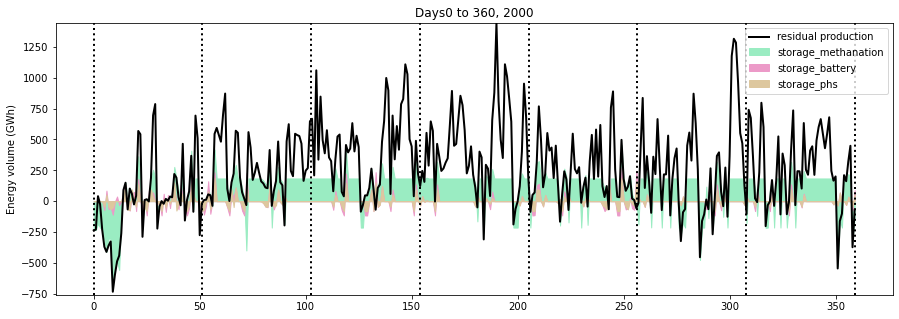

In [55]:
show_simu(0,360,df)

phs
battery
methanation


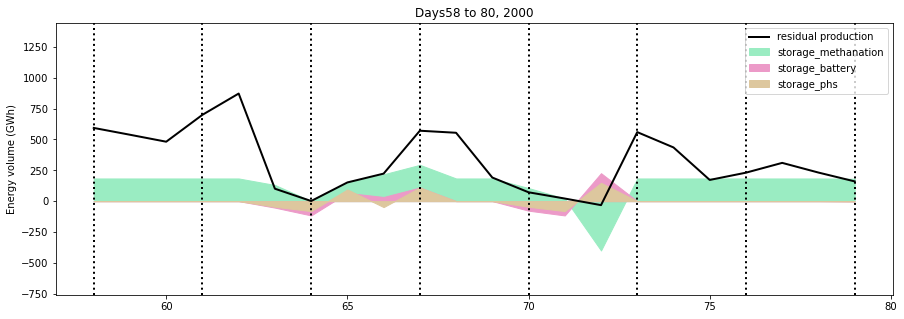

In [56]:
show_simu(58,80,df)

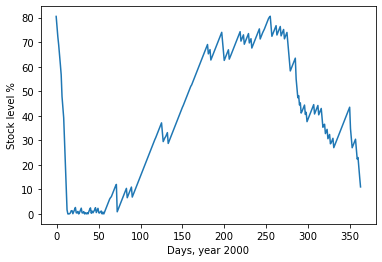

In [57]:
plt.figure()
plt.plot(simu.index-1, simu['Stored methanation'])
plt.xlabel("Days, year 2000")
plt.ylabel("Stock level %")
plt.show()

In [58]:
fig0 = go.Figure()
fig0.add_traces(go.Scatter( x = simu.index, y = data[0:364]['Stored methanation'], mode='lines', line_color ='green',opacity = 0.4, name = '2000'))
fig0.add_traces(go.Scatter( x = simu.index, y = data[364:729]['Stored methanation'], mode='lines', line_color ='blue',opacity = 0.4, name = '2001'))
fig0.add_traces(go.Scatter( x = simu.index, y = data[729:1094]['Stored methanation'], mode='lines', line_color ='yellow',opacity = 0.4, name = '2002'))
fig0.add_traces(go.Scatter( x = simu.index, y = data[1094:1459]['Stored methanation'], mode='lines', line_color ='orange',opacity = 0.4, name = '2003'))
fig0.add_traces(go.Scatter( x = simu.index, y = data[1459:1824]['Stored methanation'], mode='lines', line_color ='purple',opacity = 0.4, name = '2004'))
fig0.add_traces(go.Scatter( x = simu.index, y = data[1824:2189]['Stored methanation'], mode='lines', line_color ='pink',opacity = 0.4, name = '2005'))
fig0.add_traces(go.Scatter( x = simu.index, y = data[2189:2554]['Stored methanation'], mode='lines', line_color ='#B68100',opacity = 0.4, name = '2006'))
fig0.add_traces(go.Scatter( x = simu.index, y = data[2554:2919]['Stored methanation'], mode='lines', line_color ='#B279A4',opacity = 0.4, name = '2007'))
fig0.add_traces(go.Scatter( x = simu.index, y = simu['Stored methanation'], mode='lines',line_width=4, line_color ='red', name = 'predicted')).update_layout(
    xaxis_title="Date", yaxis_title="Stock level methanation %"
)
fig0.show()

In [51]:
# même plot pour les 'vraies' données
df_simu = data.copy()
df_simu['storage_phs']=simu_phs
df_simu['storage_battery']=simu_bat
df_simu['storage_methanation']=simu_met

phs
battery
methanation


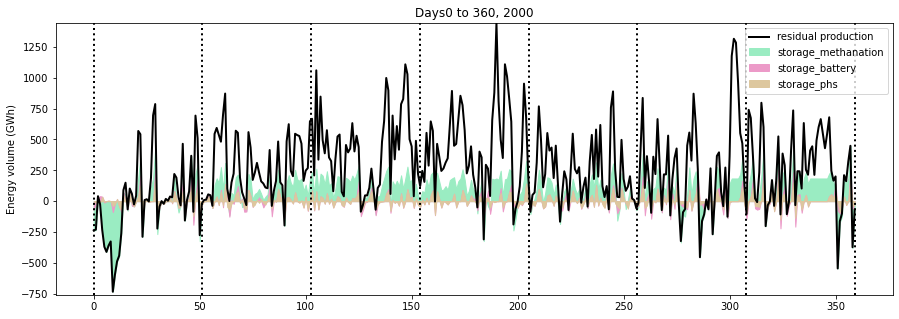

In [52]:
show_simu(0,360,df_simu)

phs
battery
methanation


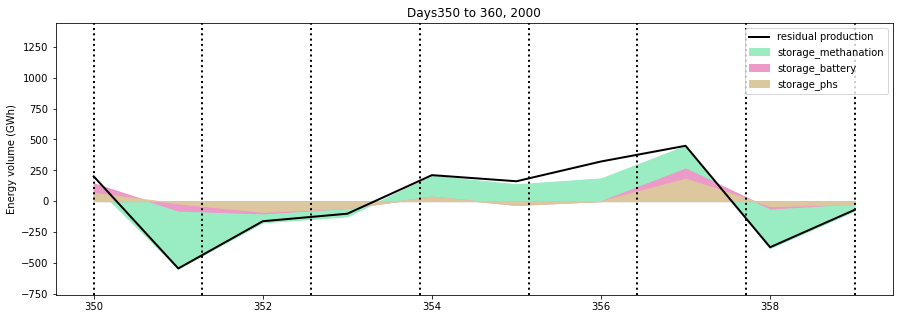

In [53]:
show_simu(350,360,df_simu)